## Train Sign Recognition

In [3]:
import cv2
import mediapipe as mp
import copy
import itertools
import glob
import os
import numpy as np
from tqdm.notebook import trange, tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, classification_report
from sklearn import metrics
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
import keras
from joblib import dump,load # save & load model
from keras.models import load_model
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import tensorflow as tf
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1080 Ti (UUID: GPU-1f6e482f-2053-a9f6-b7ed-5888013cd4db)


In [4]:
print( f"Detected GPU(s): {tf.config.experimental.list_physical_devices('GPU')}" )

Detected GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [204]:
signs = []
folder = 'asl_alphabet_train/'
for folderName in os.listdir(folder):
    signs.append(folderName)
print(signs)    

['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [205]:
signs = ['A', 'B', 'C', 'D', 'del', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'space', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [206]:
for index, i in enumerate(signs):
    print(index,':',i)

0 : A
1 : B
2 : C
3 : D
4 : del
5 : E
6 : F
7 : G
8 : H
9 : I
10 : J
11 : K
12 : L
13 : M
14 : N
15 : O
16 : P
17 : Q
18 : R
19 : S
20 : space
21 : T
22 : U
23 : V
24 : W
25 : X
26 : Y
27 : Z


In [11]:
def get_landmark_list(landmarks):
    landmark_point = []
    # Keypoint 
    for landmark in landmarks.landmark:
        #landmark_point.append([landmark.x, landmark.y, landmark.z])
        landmark_point.append([landmark.x, landmark.y])
    return landmark_point

In [12]:
def pre_process_landmark(landmark_list):
    temp_landmark_list = copy.deepcopy(landmark_list)

    # Convert to relative coordinates
    base_x, base_y = 0, 0
    for index, landmark_point in enumerate(temp_landmark_list):
        if index == 0:
            base_x, base_y = landmark_point[0], landmark_point[1]

        temp_landmark_list[index][0] = temp_landmark_list[index][0] - base_x
        temp_landmark_list[index][1] = temp_landmark_list[index][1] - base_y

    # Convert to a one-dimensional list
    temp_landmark_list = list(itertools.chain.from_iterable(temp_landmark_list))

    return temp_landmark_list

## Collect Data

In [48]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

In [13]:
data = []
folder = 'asl_alphabet_train/'
with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5) as hands:
    for label,folderName in tqdm(enumerate(signs), desc='Loading:'):
        for image_filename in os.listdir(folder + folderName):
            img_file = cv2.imread(folder + folderName + '/' + image_filename)      
            image = cv2.flip(img_file, 1)
            # Convert the BGR image to RGB before processing.
            results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_hand_landmarks:
                landmark_list = get_landmark_list(results.multi_hand_landmarks[0])
                pre_processed_landmark_list  = pre_process_landmark(landmark_list)
                #pre_processed_landmark_list = list(itertools.chain.from_iterable(landmark_list))
                pre_processed_landmark_list.append(label)
                data.append(pre_processed_landmark_list)

Loading:: |          | 0/? [00:00<?, ?it/s]

In [14]:
df = pd.DataFrame(data)

In [208]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.0,0.0,-0.086810,-0.066684,-0.147966,-0.157194,-0.170102,-0.240476,-0.165259,-0.299199,...,-0.107539,0.066877,-0.172518,0.066543,-0.227370,0.056002,-0.175225,0.044668,-0.125688,0
1,0.0,0.0,-0.109237,-0.093575,-0.170791,-0.238544,-0.173349,-0.359925,-0.151815,-0.466479,...,-0.113803,0.180992,-0.245511,0.124416,-0.272336,0.082000,-0.189661,0.074888,-0.122522,0
2,0.0,0.0,-0.119484,-0.101306,-0.185372,-0.257455,-0.182518,-0.379690,-0.159045,-0.481489,...,-0.106518,0.177456,-0.255281,0.119196,-0.275295,0.079808,-0.191880,0.075669,-0.126409,0
3,0.0,0.0,-0.118329,-0.100434,-0.179245,-0.261817,-0.170694,-0.384803,-0.145097,-0.484791,...,-0.099248,0.188970,-0.256071,0.120085,-0.274377,0.083001,-0.190868,0.080532,-0.126346,0
4,0.0,0.0,-0.120701,-0.091424,-0.186999,-0.256116,-0.183836,-0.381842,-0.163201,-0.484689,...,-0.087029,0.167943,-0.256836,0.122253,-0.273428,0.091254,-0.188119,0.085924,-0.122901,0


In [16]:
df.shape

(61115, 43)

In [17]:
df.to_csv("data/hand_42.csv", index = False)

In [207]:
df = pd.read_csv('data/hand_42.csv')

In [209]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.0,0.0,-0.086810,-0.066684,-0.147966,-0.157194,-0.170102,-0.240476,-0.165259,-0.299199,...,-0.107539,0.066877,-0.172518,0.066543,-0.227370,0.056002,-0.175225,0.044668,-0.125688,0
1,0.0,0.0,-0.109237,-0.093575,-0.170791,-0.238544,-0.173349,-0.359925,-0.151815,-0.466479,...,-0.113803,0.180992,-0.245511,0.124416,-0.272336,0.082000,-0.189661,0.074888,-0.122522,0
2,0.0,0.0,-0.119484,-0.101306,-0.185372,-0.257455,-0.182518,-0.379690,-0.159045,-0.481489,...,-0.106518,0.177456,-0.255281,0.119196,-0.275295,0.079808,-0.191880,0.075669,-0.126409,0
3,0.0,0.0,-0.118329,-0.100434,-0.179245,-0.261817,-0.170694,-0.384803,-0.145097,-0.484791,...,-0.099248,0.188970,-0.256071,0.120085,-0.274377,0.083001,-0.190868,0.080532,-0.126346,0
4,0.0,0.0,-0.120701,-0.091424,-0.186999,-0.256116,-0.183836,-0.381842,-0.163201,-0.484689,...,-0.087029,0.167943,-0.256836,0.122253,-0.273428,0.091254,-0.188119,0.085924,-0.122901,0


<AxesSubplot:xlabel='42', ylabel='count'>

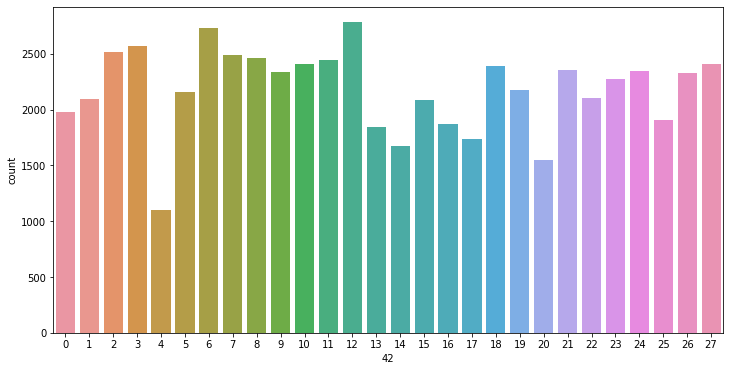

In [210]:
plt.figure(figsize=(12,6))
sns.countplot(x= str(df.shape[1]-1), data=df)

In [20]:
df_shuffled = df.sample(frac=1).reset_index(drop=True)

In [21]:
df_shuffled.to_csv("data/hand_42_shuffled.csv", index = False)

## Preprocessing

In [211]:
df = pd.read_csv('data/hand_42_shuffled.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.0,0.0,-0.064997,-0.099911,-0.069222,-0.216890,0.015125,-0.271871,0.085033,-0.247335,...,-0.206529,0.178049,-0.170722,0.249379,-0.238370,0.298551,-0.290769,0.347979,-0.345135,10
1,0.0,0.0,-0.134591,-0.040712,-0.202554,-0.123021,-0.263737,-0.180160,-0.299763,-0.251939,...,-0.278718,-0.008644,-0.274063,-0.111019,-0.386786,-0.178661,-0.381984,-0.216490,-0.356171,3
2,0.0,0.0,-0.110208,0.022632,-0.204340,-0.020149,-0.284879,-0.062564,-0.368064,-0.098021,...,-0.415765,-0.016628,-0.243216,-0.052186,-0.337372,-0.106013,-0.381117,-0.167129,-0.408367,2
3,0.0,0.0,0.004047,-0.003976,0.012934,0.003421,0.029799,0.042800,0.051391,0.070174,...,0.117331,0.021889,-0.055994,0.039228,0.017604,0.046497,0.059710,0.055066,0.081579,14
4,0.0,0.0,-0.054242,-0.086916,-0.060029,-0.184459,-0.053523,-0.253934,-0.042478,-0.292820,...,-0.158116,0.132788,-0.118668,0.129921,-0.172116,0.082942,-0.171654,0.051102,-0.166066,23


In [212]:
X = df.iloc[:, :df.shape[1]-1]
y = df.iloc[:,df.shape[1]-1]

In [213]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.0,0.0,-0.064997,-0.099911,-0.069222,-0.216890,0.015125,-0.271871,0.085033,-0.247335,...,0.069876,-0.206529,0.178049,-0.170722,0.249379,-0.238370,0.298551,-0.290769,0.347979,-0.345135
1,0.0,0.0,-0.134591,-0.040712,-0.202554,-0.123021,-0.263737,-0.180160,-0.299763,-0.251939,...,-0.240966,-0.278718,-0.008644,-0.274063,-0.111019,-0.386786,-0.178661,-0.381984,-0.216490,-0.356171
2,0.0,0.0,-0.110208,0.022632,-0.204340,-0.020149,-0.284879,-0.062564,-0.368064,-0.098021,...,-0.257773,-0.415765,-0.016628,-0.243216,-0.052186,-0.337372,-0.106013,-0.381117,-0.167129,-0.408367
3,0.0,0.0,0.004047,-0.003976,0.012934,0.003421,0.029799,0.042800,0.051391,0.070174,...,0.052010,0.117331,0.021889,-0.055994,0.039228,0.017604,0.046497,0.059710,0.055066,0.081579
4,0.0,0.0,-0.054242,-0.086916,-0.060029,-0.184459,-0.053523,-0.253934,-0.042478,-0.292820,...,-0.028182,-0.158116,0.132788,-0.118668,0.129921,-0.172116,0.082942,-0.171654,0.051102,-0.166066


In [214]:
y.head()

0    10
1     3
2     2
3    14
4    23
Name: 42, dtype: int64

## Split Train & Test

In [215]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state = 11 )

<AxesSubplot:xlabel='42', ylabel='count'>

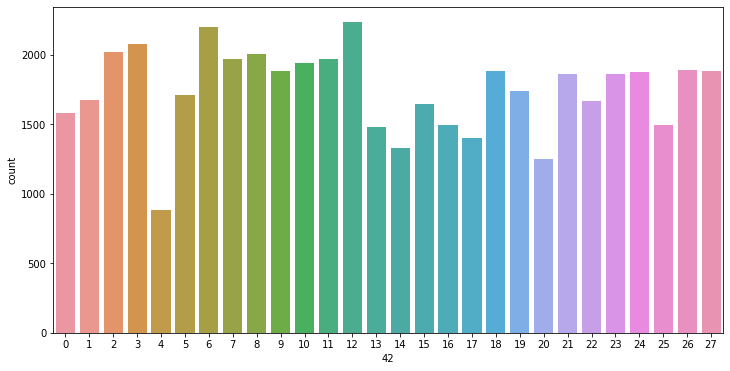

In [216]:
df_y_train = pd.DataFrame(y_train)
plt.figure(figsize=(12,6))
sns.countplot(x = '42' , data=df_y_train)

In [217]:
df_y_train.shape

(48892, 1)

<AxesSubplot:xlabel='42', ylabel='count'>

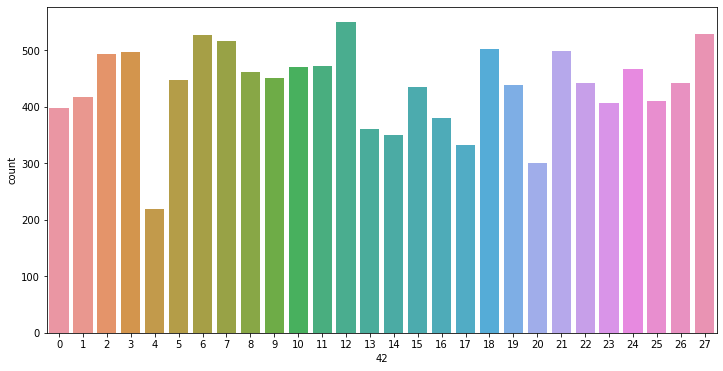

In [218]:
df_y_test = pd.DataFrame(y_test)
plt.figure(figsize=(12,6))
sns.countplot(x = '42' , data=df_y_test)

In [219]:
df_y_test.shape

(12223, 1)

## SVM

In [220]:
clf_svm = svm.SVC(decision_function_shape='ovr')
clf_svm.fit(X_train, y_train)
y_pred_svm = clf_svm.predict(X_test)

In [221]:
print("SVM Accuracy:",metrics.accuracy_score(y_test, y_pred_svm))

SVM Accuracy: 0.9429763560500696


In [222]:
dump(clf_svm, 'model/hg_svm_42.joblib')  

['models/hg_svm_42.joblib']

## Random Forest

In [223]:
clf_rf = RandomForestClassifier(criterion = 'entropy', n_estimators  = 100)
clf_rf.fit(X_train, y_train)
y_pred_rf = clf_rf.predict(X_test)

In [224]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))

Accuracy: 0.961956966374867


In [225]:
dump(clf_rf, 'model/hg_rf_42.joblib')  

['models/hg_rf_42.joblib']

## MLP

In [226]:
y_train_ohe = keras.utils.to_categorical(y_train, len(signs))
y_test_ohe = keras.utils.to_categorical(y_test, len(signs))

In [277]:
model = Sequential()
model.add(Dense(units = 84, kernel_initializer = 'uniform', activation = 'relu', input_dim = 42))
model.add(Dense(units = 56, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(units = len(signs), kernel_initializer = 'uniform', activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 84)                3612      
_________________________________________________________________
dense_100 (Dense)            (None, 56)                4760      
_________________________________________________________________
dense_101 (Dense)            (None, 28)                1596      
Total params: 9,968
Trainable params: 9,968
Non-trainable params: 0
_________________________________________________________________


In [278]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model/model_hg_42.hdf5', save_best_only=True, monitor="val_accuracy", mode='max', save_weights_only=False)  

In [279]:
hist = model.fit ( X_train, y_train_ohe, validation_data=(X_test,y_test_ohe), batch_size=32, epochs=50, callbacks=[checkpoint] )

Epoch 1/50
1528/1528 [==============================] - 4s 3ms/step - loss: 1.9678 - accuracy: 0.3959 - val_loss: 0.8956 - val_accuracy: 0.7308
Epoch 2/50
1528/1528 [==============================] - 4s 3ms/step - loss: 0.7943 - accuracy: 0.7778 - val_loss: 0.5859 - val_accuracy: 0.8478
Epoch 3/50
1528/1528 [==============================] - 4s 3ms/step - loss: 0.5294 - accuracy: 0.8605 - val_loss: 0.4374 - val_accuracy: 0.8959
Epoch 4/50
1528/1528 [==============================] - 4s 3ms/step - loss: 0.4085 - accuracy: 0.8967 - val_loss: 0.3726 - val_accuracy: 0.9041
Epoch 5/50
1528/1528 [==============================] - 4s 3ms/step - loss: 0.3526 - accuracy: 0.9118 - val_loss: 0.3338 - val_accuracy: 0.9138
Epoch 6/50
1528/1528 [==============================] - 4s 3ms/step - loss: 0.3156 - accuracy: 0.9217 - val_loss: 0.3068 - val_accuracy: 0.9233
Epoch 7/50
1528/1528 [==============================] - 4s 3ms/step - loss: 0.2860 - accuracy: 0.9267 - val_loss: 0.2899 - val_accuracy:

In [287]:
# Evaluate the model from the last epoch
score = model.evaluate(X_test, y_test_ohe, verbose=0)
print('Model from the last epoch:')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Load and evaluate the model from the best epoch
best_model = load_model('model/model_hg_42.hdf5', compile=True )
score = best_model.evaluate(X_test, y_test_ohe, verbose=0)
print('Model from the best epoch:')
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model from the last epoch:
Test loss: 0.15695339441299438
Test accuracy: 0.9586844444274902
Model from the best epoch:
Test loss: 0.15315772593021393
Test accuracy: 0.9594207406044006


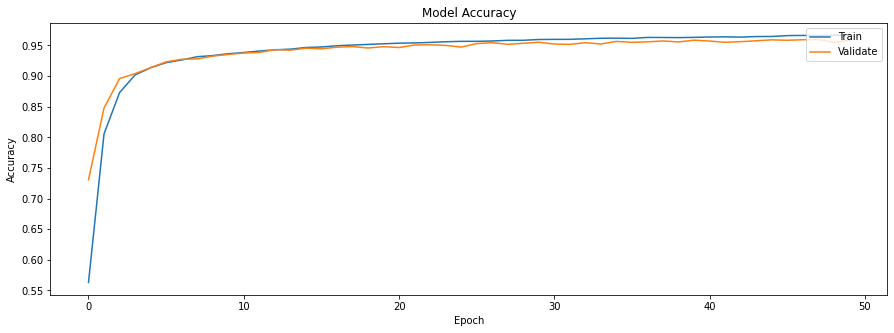

In [288]:
plt.figure(figsize=(15,5))
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper right')
plt.show()

## Test Model Real-time

In [289]:
# For webcam input:
mode = 1
ml_model = load('model/hg_svm_42.joblib') #mode 0
mlp_model = load_model('model/model_hg_42.hdf5', compile=True ) #mode 1
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    min_detection_confidence=0.6,
    max_num_hands=1,
    min_tracking_confidence=0.6) as hands:
    sen = ''
    cf = []
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue

        # Flip the image horizontally for a later selfie-view display, and convert
        # the BGR image to RGB.
        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        results = hands.process(image)

        # Draw the hand annotations on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        if results.multi_hand_landmarks:           
            mp_drawing.draw_landmarks(image, results.multi_hand_landmarks[0], mp_hands.HAND_CONNECTIONS)            
            pre_processed_landmark_list  = pre_process_landmark(get_landmark_list(results.multi_hand_landmarks[0]))
            #For Traditional ML
            if mode == 0:
                prediction = ml_model.predict([pre_processed_landmark_list])
                result = signs[prediction[0]]
            #For MLP
            elif mode == 1:   
                prediction = mlp_model.predict([pre_processed_landmark_list])
                maxindex = int(np.argmax(prediction))
                result = signs[maxindex]
            if not cf:
                cf.append(result)
            elif result in cf:
                cf.append(result)
            elif result not in cf:
                cf.clear()
            if len(cf) > 50:
                if 'del' in cf:
                    if sen:
                        sen = sen[:-1]
                elif 'space'  in cf:
                    sen += ' '
                else:
                    sen += result   
                cf.clear()
                image = cv2.putText(image, 'Confirmed', 
                                (280, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                                (0, 255, 0),2,cv2.LINE_AA)
            image = cv2.putText(image, 'Prediction: '+ result, 
                                (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                                (0, 0, 255),2,cv2.LINE_AA)
        image = cv2.putText(image, 'Result: '+ sen, 
                            (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, 
                            (0, 0, 255),2,cv2.LINE_AA)
        cv2.imshow('MediaPipe Hands', image)       
        if (cv2.waitKey(1)== 27):
            break
cv2.destroyAllWindows()     # close all OpenCV windows
if cap.isOpened():
    cap.release()  